It can be useful to see how LSST performs with a mixed vendor focal plane. In this notebook, we set some chips to be from "vendor 1" and the rest from "vendor 2", and look at how the coverage of the sky looks if we only include chips from a single vendor.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler
import healpy as hp

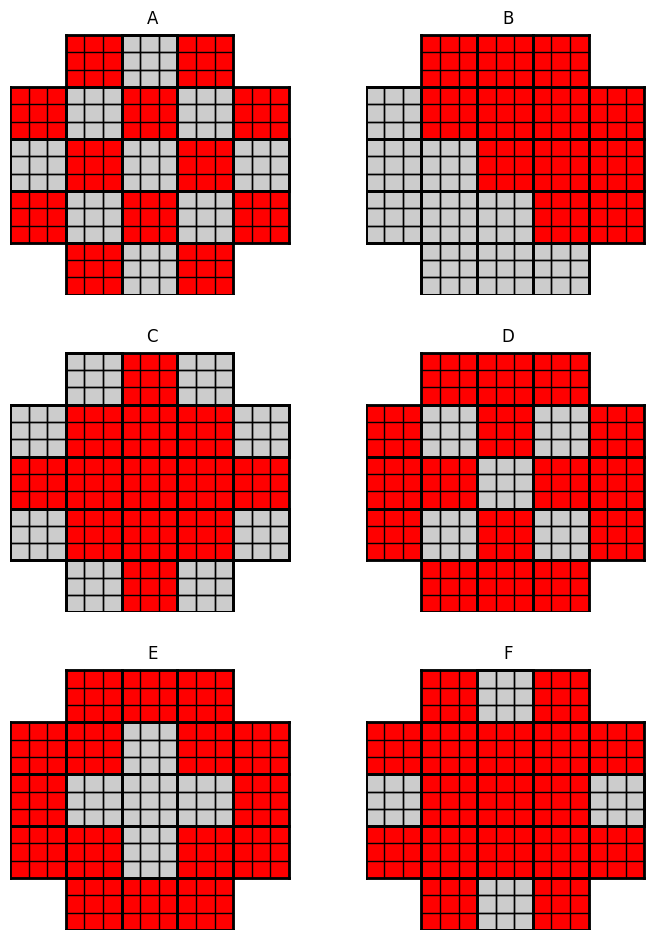

In [2]:
def drawRaft(ax, xLL, yLL, color='#CCCCCC', width = 1.0, height = 1.0, plotCCDs = 1):

    ax.add_patch(Rectangle((yLL, xLL), width, height, fill=True, color=color, ec='k'))
    # raft frame
    ax.plot([xLL, xLL], [yLL, yLL+height], 'black', linewidth=2)
    ax.plot([xLL+width, xLL+width], [yLL, yLL+height], 'black', linewidth=2)
    ax.plot([xLL, xLL+width], [yLL, yLL], 'black', linewidth=2)
    ax.plot([xLL, xLL+width], [yLL+height, yLL+height], 'black', linewidth=2)

    if plotCCDs: 
        ax.plot([xLL+width/3.0, xLL+width/3.0], [yLL, yLL+height], 'black', linewidth=1)
        ax.plot([xLL+2*width/3.0, xLL+2*width/3.0], [yLL, yLL+height], 'black', linewidth=1)
        ax.plot([xLL, xLL+width], [yLL+height/3.0, yLL+height/3.0], 'black', linewidth=1)
        ax.plot([xLL, xLL+width], [yLL+2*height/3.0, yLL+2*height/3.0], 'black', linewidth=1)

def plotHybridFOV(axes, option):

    # title 
    axes.set_title(option)

    # axes limits
    axes.set_xlim(0, 5.1)
    axes.set_ylim(0, 5.1)

    for i in (1, 2, 3): 
        for j in range(0,5):
            drawRaft(axes, i, j, color = 'red')
    for i in (0, 4): 
        for j in range(1,4):
            drawRaft(axes, i, j, color = 'red')
            
    if (option == 'A'):
        drawRaft(axes, 0, 2)
        drawRaft(axes, 1, 1)
        drawRaft(axes, 1, 3)
        drawRaft(axes, 2, 0)
        drawRaft(axes, 2, 2)
        drawRaft(axes, 2, 4)
        drawRaft(axes, 3, 1)
        drawRaft(axes, 3, 3)
        drawRaft(axes, 4, 2)

    if (option == 'B'):
        drawRaft(axes, 0, 1)
        drawRaft(axes, 0, 2)
        drawRaft(axes, 0, 3)
        drawRaft(axes, 1, 0)
        drawRaft(axes, 1, 1)
        drawRaft(axes, 1, 2)
        drawRaft(axes, 2, 0)
        drawRaft(axes, 2, 1)
        drawRaft(axes, 3, 0)

    if (option == 'C'):
        drawRaft(axes, 0, 1)
        drawRaft(axes, 0, 3)
        drawRaft(axes, 1, 0)
        drawRaft(axes, 1, 4)
        drawRaft(axes, 3, 0)
        drawRaft(axes, 3, 4)
        drawRaft(axes, 4, 1)
        drawRaft(axes, 4, 3)

    if (option == 'D'):
        drawRaft(axes, 1, 1)
        drawRaft(axes, 1, 3)
        drawRaft(axes, 2, 2)
        drawRaft(axes, 3, 1)
        drawRaft(axes, 3, 3)

    if (option == 'E'):
        drawRaft(axes, 1, 2)
        drawRaft(axes, 2, 1)
        drawRaft(axes, 2, 2)
        drawRaft(axes, 2, 3)
        drawRaft(axes, 3, 2)

    if (option == 'F'):
        drawRaft(axes, 0, 2)
        drawRaft(axes, 2, 0)
        drawRaft(axes, 2, 4)
        drawRaft(axes, 4, 2)
     

### plot a 6-panel figure with hybrid focal plane realizations
def plotHybridFOVoptions(): 

    # Create figure and subplots
    fig = plt.figure(figsize=(8, 10))
    # this work well in *.py version but not so well in ipython notebook
    fig.subplots_adjust(wspace=0.25, left=0.1, right=0.9, bottom=0.05, top=0.95)

    optionsList = ('A', 'B', 'C', 'D', 'E', 'F')
    plotNo = 0
    for option in optionsList:
        plotNo += 1
        axes = plt.subplot(3, 2, plotNo, xticks=[], yticks=[], frameon=False)
        plotHybridFOV(axes, option)

    #plt.savefig('./HybridFOVoptions.png')
    plt.show() 


### 
plotHybridFOVoptions()


In [3]:
# Set up each configuration to return a list of chips in a way MAF understands
# Let's do this for a hybrid focal plane
def makeChipList(raftConfig):
    raftDict = {'R:1,0':1,
                'R:2,0':2 ,
                'R:3,0':3 ,
                'R:0,1':4 ,
                'R:1,1':5 ,
                'R:2,1':6 ,
                'R:3,1':7 ,
                'R:4,1':8 ,
                'R:0,2':9 ,
                'R:1,2':10,
                'R:2,2':11,
                'R:3,2':12,
                'R:4,2':13,
                'R:0,3':14,
                'R:1,3':15,
                'R:2,3':16,
                'R:3,3':17,
                'R:4,3':18,
                'R:1,4':19,
                'R:2,4':20,
                'R:3,4':21}

    sensors = ['S:0,0', 'S:0,1', 'S:0,2',
               'S:1,0', 'S:1,1', 'S:1,2',
               'S:2,0', 'S:2,1', 'S:2,2',]


    raftReverseDict = {}
    for key in raftDict:
        raftReverseDict[raftDict[key]] = key
    raftConfigs = {'A':{'rafts2':[1,3,4,6,8,10,12,14,16,18,19,21], 'rafts1':[2,5,7,9,11,13,15,17,20]},
                   'B':{'rafts2':[7,8,11,12,13,15,16,17,18,19,20,21], 'rafts1':[1,2,3,4,5,6,9,10,14]},
                   'C':{'rafts2':[2,5,6,7,9,10,11,12,13,15,16,17,20], 'rafts1':[1,3,4,8,14,18,19,21]},
                   'D':{'rafts2':[1,2,3,4,6,8,9,10,12,13,14,16,18,19,20,21], 'rafts1':[5,7,11,15,17]},
                   'E':{'rafts2':[1,2,3,4,5,7,8,9,13,14,15,17,18,19,20,21], 'rafts1':[6,10,11,12,16]},
                   'F':{'rafts2':[1,2,3,4,5,7,8,9,13,14,15,17,18,19,20,21], 'rafts1':[6,10,11,12,16]}
                  }
    rafts1 = []
    rafts2 = []
    for indx in raftConfigs[raftConfig]['rafts1']:
        rafts1.append(raftReverseDict[indx])

    for indx in raftConfigs[raftConfig]['rafts2']:
        rafts2.append(raftReverseDict[indx])

    chips1 = []
    for raft in rafts1:
        for sensor in sensors:
            chips1.append(raft+' '+sensor)

    chips2 = []
    for raft in rafts2:
        for sensor in sensors:
            chips2.append(raft+' '+sensor)
    return chips1, chips2

In [4]:
chips1, chips2 = makeChipList('E')

In [5]:
print 'chips1', chips1
print 'chips2', chips2

chips1 ['R:2,1 S:0,0', 'R:2,1 S:0,1', 'R:2,1 S:0,2', 'R:2,1 S:1,0', 'R:2,1 S:1,1', 'R:2,1 S:1,2', 'R:2,1 S:2,0', 'R:2,1 S:2,1', 'R:2,1 S:2,2', 'R:1,2 S:0,0', 'R:1,2 S:0,1', 'R:1,2 S:0,2', 'R:1,2 S:1,0', 'R:1,2 S:1,1', 'R:1,2 S:1,2', 'R:1,2 S:2,0', 'R:1,2 S:2,1', 'R:1,2 S:2,2', 'R:2,2 S:0,0', 'R:2,2 S:0,1', 'R:2,2 S:0,2', 'R:2,2 S:1,0', 'R:2,2 S:1,1', 'R:2,2 S:1,2', 'R:2,2 S:2,0', 'R:2,2 S:2,1', 'R:2,2 S:2,2', 'R:3,2 S:0,0', 'R:3,2 S:0,1', 'R:3,2 S:0,2', 'R:3,2 S:1,0', 'R:3,2 S:1,1', 'R:3,2 S:1,2', 'R:3,2 S:2,0', 'R:3,2 S:2,1', 'R:3,2 S:2,2', 'R:2,3 S:0,0', 'R:2,3 S:0,1', 'R:2,3 S:0,2', 'R:2,3 S:1,0', 'R:2,3 S:1,1', 'R:2,3 S:1,2', 'R:2,3 S:2,0', 'R:2,3 S:2,1', 'R:2,3 S:2,2']
chips2 ['R:1,0 S:0,0', 'R:1,0 S:0,1', 'R:1,0 S:0,2', 'R:1,0 S:1,0', 'R:1,0 S:1,1', 'R:1,0 S:1,2', 'R:1,0 S:2,0', 'R:1,0 S:2,1', 'R:1,0 S:2,2', 'R:2,0 S:0,0', 'R:2,0 S:0,1', 'R:2,0 S:0,2', 'R:2,0 S:1,0', 'R:2,0 S:1,1', 'R:2,0 S:1,2', 'R:2,0 S:2,0', 'R:2,0 S:2,1', 'R:2,0 S:2,2', 'R:3,0 S:0,0', 'R:3,0 S:0,1', 'R:3,0 S:

In [6]:
database = 'enigma_1189_sqlite.db'
opsdb = db.OpsimDatabase(database)
outDir = 'Camera'
resultsDb = db.ResultsDb(outDir=outDir)
nside = 512

In [7]:
# Dithering off, just count the number of observations using only vendor 1, or only vendor 2 and 
# compare to the regular full focal plane.
sqlWhere = 'filter = "u" and night < 730 and fieldRA < %f and fieldDec > %f and fieldDec < 0' % (np.radians(15), np.radians(-15))
metric = metrics.CountMetric('expMJD')
slicer = slicers.HealpixSlicer(latCol='fieldDec', lonCol='fieldRA', nside=nside)
slicer2 = slicers.HealpixSlicer(latCol='fieldDec', lonCol='fieldRA',nside=nside, useCamera=True, chipNames=chips2)
slicer3 = slicers.HealpixSlicer(latCol='fieldDec', lonCol='fieldRA',nside=nside, useCamera=True, chipNames=chips1)
bundle1 = metricBundles.MetricBundle(metric,slicer,sqlWhere, metadata='No camera')
bundle2 = metricBundles.MetricBundle(metric,slicer2,sqlWhere, metadata='Chips2')
bundle3 = metricBundles.MetricBundle(metric,slicer3,sqlWhere, metadata='Chips1')
bd = metricBundles.makeBundlesDictFromList([bundle1,bundle2,bundle3])
bg = metricBundles.MetricBundleGroup(bd,opsdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Querying database with constraint filter = "u" and night < 730 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0
Found 252 visits
Running:  ['opsim_Count_expMJD_Chips2_HEAL']


/Users/yoachim/gitRepos/sims_coordUtils/python/lsst/sims/coordUtils/CameraUtils.py:373: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.019349818465 -0.020521110226

  category=MultipleChipWarning)


Completed metric generation.
Running:  ['opsim_Count_expMJD_Chips1_HEAL']
Completed metric generation.
Running:  ['opsim_Count_expMJD_No_camera_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


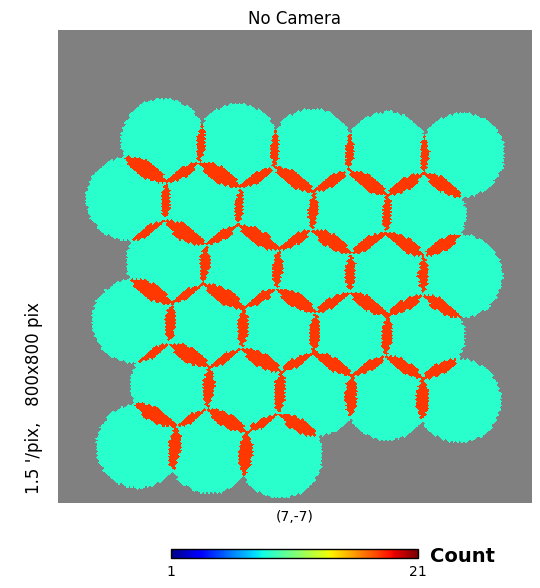

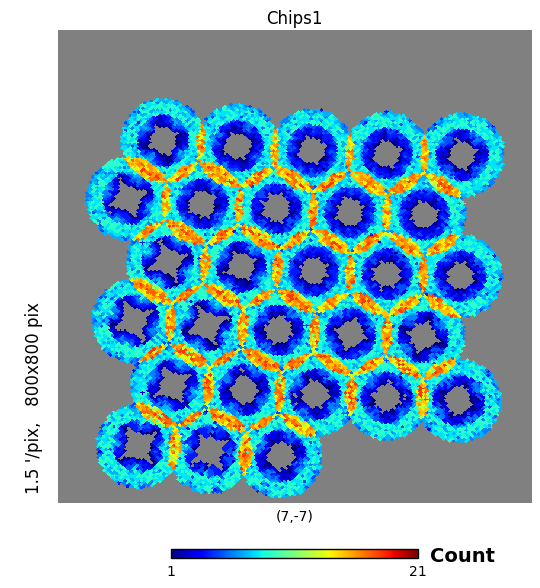

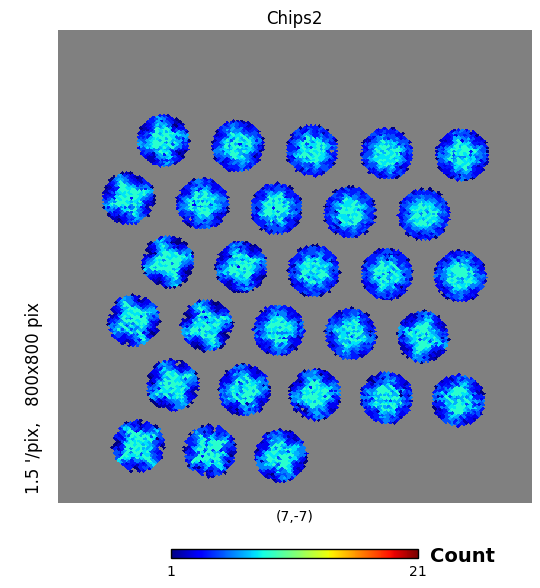

In [8]:
hp.gnomview(bundle1.metricValues, xsize=800,ysize=800, rot=(7,-7,0), title='No Camera', unit='Count', min=1,max=21)
hp.gnomview(bundle2.metricValues, xsize=800,ysize=800, rot=(7,-7,0),title='Chips1', unit='Count', min=1,max=21)
hp.gnomview(bundle3.metricValues, xsize=800,ysize=800, rot=(7,-7,0),title='Chips2', unit='Count', min=1,max=21)

In [9]:
# Dithering on, just count the number of exposures using only vendor 1, only vendor 2, and all spots.
sqlWhere = 'filter = "u" and night < 730 and fieldRA < %f and fieldDec > %f and fieldDec < 0' % (np.radians(15), np.radians(-15))
metric = metrics.CountMetric('expMJD')
slicer = slicers.HealpixSlicer(latCol='ditheredDec', lonCol='ditheredRA', nside=nside)
slicer2 = slicers.HealpixSlicer(latCol='ditheredDec', lonCol='ditheredRA',nside=nside, useCamera=True, chipNames=chips2)
slicer3 = slicers.HealpixSlicer(latCol='ditheredDec', lonCol='ditheredRA',nside=nside, useCamera=True, chipNames=chips1)
bundle1 = metricBundles.MetricBundle(metric,slicer,sqlWhere, metadata='No camera')
bundle2 = metricBundles.MetricBundle(metric,slicer2,sqlWhere, metadata='Chips2')
bundle3 = metricBundles.MetricBundle(metric,slicer3,sqlWhere, metadata='Chips1')
bd = metricBundles.makeBundlesDictFromList([bundle1,bundle2,bundle3])
bg = metricBundles.MetricBundleGroup(bd,opsdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Querying database with constraint filter = "u" and night < 730 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0
Found 252 visits
Running:  ['opsim_Count_expMJD_Chips2_HEAL']


/Users/yoachim/gitRepos/sims_coordUtils/python/lsst/sims/coordUtils/CameraUtils.py:373: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.020232169388 -0.020520010255

  category=MultipleChipWarning)


Completed metric generation.
Running:  ['opsim_Count_expMJD_Chips1_HEAL']
Completed metric generation.
Running:  ['opsim_Count_expMJD_No_camera_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


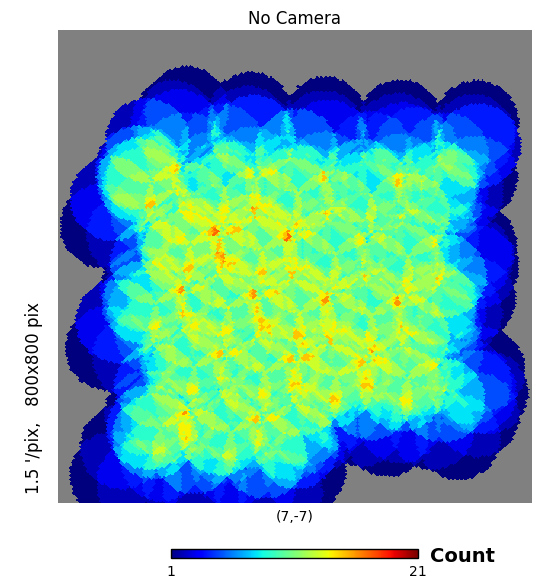

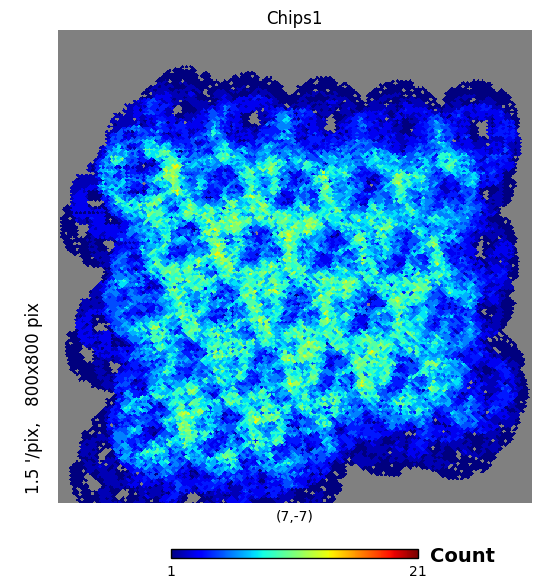

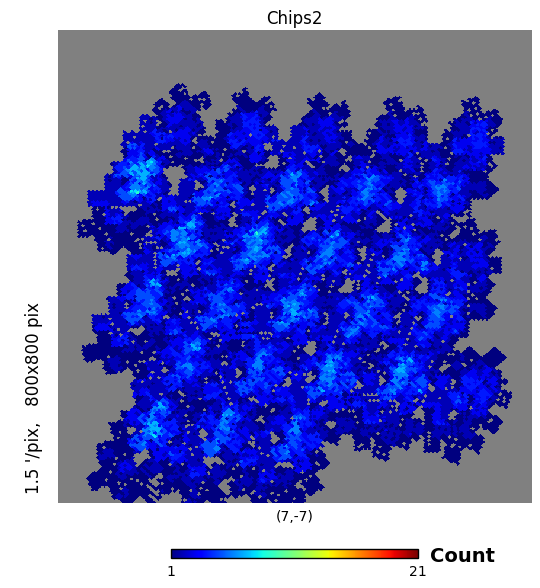

In [10]:
hp.gnomview(bundle1.metricValues, xsize=800,ysize=800, rot=(7,-7,0), title='No Camera', unit='Count', min=1,max=21)
hp.gnomview(bundle2.metricValues, xsize=800,ysize=800, rot=(7,-7,0),title='Chips1', unit='Count', min=1,max=21)
hp.gnomview(bundle3.metricValues, xsize=800,ysize=800, rot=(7,-7,0),title='Chips2', unit='Count', min=1,max=21)